# ACCF

Interface to the ACCF (algorithmic climate change functions) from the DLR library [climaccf](https://github.com/dlr-pa/climaccf)

## References

- Dietmüller, Simone. “Dlr-Pa/Climaccf: Dataset Update for GMDD.” Zenodo, September 13, 2022. https://doi.org/10.5281/zenodo.7074582.
- Dietmüller, Simone, Sigrun Matthes, Katrin Dahlmann, Hiroshi Yamashita, Abolfazl Simorgh, Manuel Soler, Florian Linke, et al. “A Python Library for Computing Individual and Merged Non-CO<sub>2</sub> Algorithmic Climate Change Functions: CLIMaCCF V1.0.” Preprint. Atmospheric sciences, October 17, 2022. https://doi.org/10.5194/gmd-2022-203.

## Requirements

- Requires Python 3.9 or earlier

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pycontrails import (
    Flight,
    GeoVectorDataset,
    MetDataArray,
    MetDataset,
)
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.accf import ACCF
from pycontrails.physics import units

## Set Domain

time / altitude

In [2]:
time_bounds = ("2022-01-01 12:00:00", "2022-01-01 15:00:00")
pressure_levels = [200, 225, 250]

## Download meteorology data from ECMWF

This demo uses [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) via the [Copernicus Data Store (CDS)](https://cds.climate.copernicus.eu/) for met data.
This requires account with [Copernicus Data Portal](https://cds.climate.copernicus.eu/cdsapp#!/home) and local `~/.cdsapirc` file with credentials.

In [3]:
# pressure level data
era5_pl = ERA5(
    time=time_bounds,
    variables=[
        "air_temperature",
        "specific_humidity",
        "potential_vorticity",
        "geopotential",
        "relative_humidity",
        "northward_wind",
        "eastward_wind",
    ],
    pressure_levels=pressure_levels,
)

# single level data (radiation)
era5_sl = ERA5(
    time=time_bounds,
    variables=["surface_solar_downward_radiation", "top_net_thermal_radiation"],
)

pl = era5_pl.open_metdataset(xr_kwargs=dict(parallel=False))
sl = era5_sl.open_metdataset(xr_kwargs=dict(parallel=False))

## Create example flight

In [4]:
# Note: ACCF output is in K/kg of fuel so you will need to provide fuel burn of the flight to get impact in K
n = 10000
longitude = np.linspace(45, 58, n) + np.linspace(0, 1, n)
latitude = np.linspace(45, 54, n) - np.linspace(0, 1, n)
altitude = units.pl_to_m(225) * np.ones(n)

start = np.datetime64(time_bounds[0])
end = start + np.timedelta64(90, "m")  # 90 minute flight
time = pd.date_range(start, end, periods=n)
fl = Flight(
    longitude=longitude,
    latitude=latitude,
    altitude=altitude,
    time=time,
    aircraft_type="B737",
    flight_id=17,
)
fl["fuel_flow"] = np.linspace(2.1, 2.4, n)  # kg/s

In [5]:
fl

Flight [5 keys x 10000 length, 3 attributes]
	Keys: longitude, latitude, time, altitude, fuel_flow
	Attributes:
	time                [2022-01-01 12:00:00, 2022-01-01 13:30:00]
	longitude           [45.0, 59.0]
	latitude            [45.0, 53.0]
	altitude            [11037.011260104731, 11037.011260104731]
	aircraft_type       B737
	flight_id           17
	crs                 EPSG:4326

## Initialize ACCF model and evaluate on flight

In [6]:
ac = ACCF(met=pl, surface=sl)

In [7]:
# Evaluate ACCFs over this flight
fl = ac.eval(fl)

Forecast step: 1 hour




## Explore the output

Raw output:

In [8]:
fl

Flight [25 keys x 10000 length, 3 attributes]
	Keys: longitude, latitude, time, altitude, fuel_flow, ..., Fin
	Attributes:
	time                [2022-01-01 12:00:00, 2022-01-01 13:30:00]
	longitude           [45.0, 59.0]
	latitude            [45.0, 53.0]
	altitude            [11037.011260104731, 11037.011260104731]
	aircraft_type       B737
	flight_id           17
	crs                 EPSG:4326

Now convert fuel flow to total fuel burned by waypoint, and get the impact of each flight waypoint and plot

In [9]:
# Waypoint duration in seconds
# last point set to 0
dt_sec = np.diff(fl["time"], append=fl["time"][-1]) / np.timedelta64(1, "s")

# kg fuel per contrail
fuel_burn = fl["fuel_flow"] * dt_sec

# Get impacts in degrees K per waypoint
warming_contrails = fuel_burn * fl["aCCF_Cont"]
warming_merged = fuel_burn * fl["aCCF_merged"]

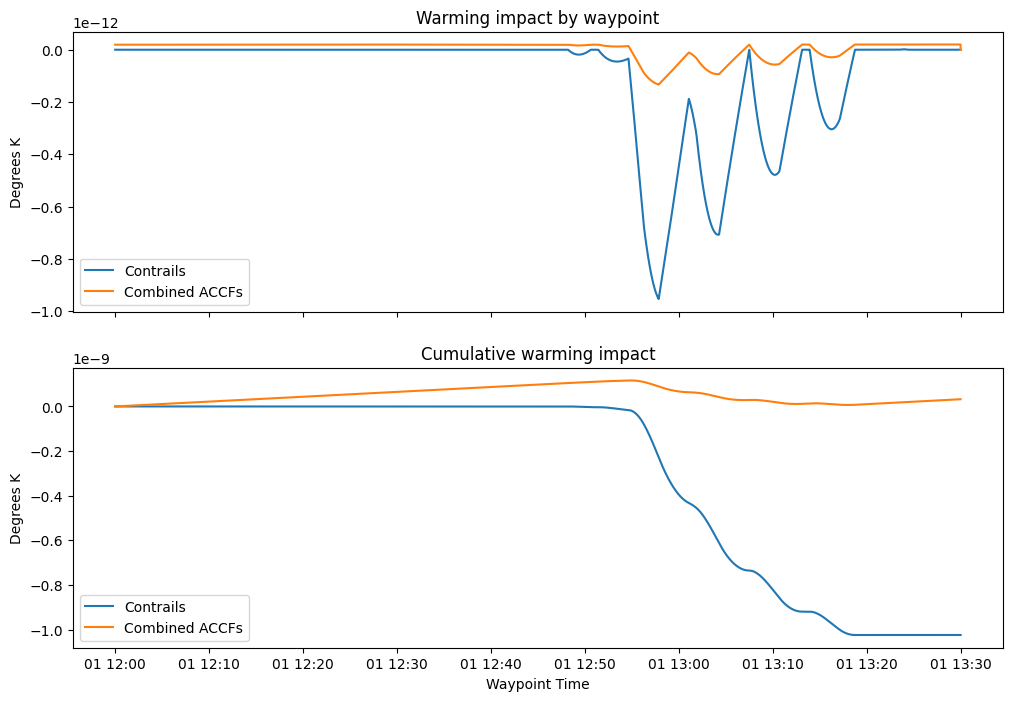

In [10]:
f, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
ax[0].plot(fl["time"], warming_contrails, label="Contrails")
ax[0].plot(fl["time"], warming_merged, label="Combined ACCFs")
ax[0].set_ylabel("Degrees K")
ax[0].set_title("Warming impact by waypoint")
ax[0].legend()

ax[1].plot(fl["time"], np.cumsum(warming_contrails), label="Contrails")
ax[1].plot(fl["time"], np.cumsum(warming_merged), label="Combined ACCFs")
ax[1].legend()
ax[1].set_xlabel("Waypoint Time")
ax[1].set_ylabel("Degrees K")
_ = ax[1].set_title("Cumulative warming impact")

## Grid ACCF with Parameters

In [15]:
ac = ACCF(pl, sl,{'emission_scenario':"future_scenario",'accf_v':"V1.1",'horizontal_resolution':0.25})
ds = ac.eval(pl) # This will evaluate over the met grid

Forecast step: 1 hour




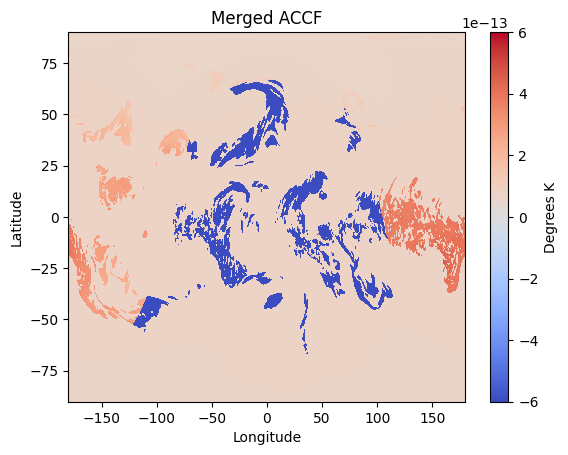

In [33]:
fig, ax = plt.subplots()
p = ax.pcolor(ds['longitude'].data,ds['latitude'].data,ds['aCCF_merged'].data[:,:,0,0].T,cmap="coolwarm",vmin=-6e-13, vmax=6e-13)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Merged ACCF')
cbar = plt.colorbar(p)
_ = cbar.set_label('Degrees K')